In [2]:
%load_ext autoreload
%autoreload 2

from datetime import datetime, timedelta, time
import pandas as pd
import numpy as np
import datajoint as dj
dj.conn(reset=True)
from pipeline import pipeline_tools, lab, experiment, behavioranal
import matplotlib.pyplot as plt
import decimal
from scipy.stats import norm
import scipy
%matplotlib inline
from plot.plot_behavior import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Connecting hanhou@mesoscale-activity.datajoint.io:3306


# Get a rough idea of the database

### Show entity relationship diagram (ERD)

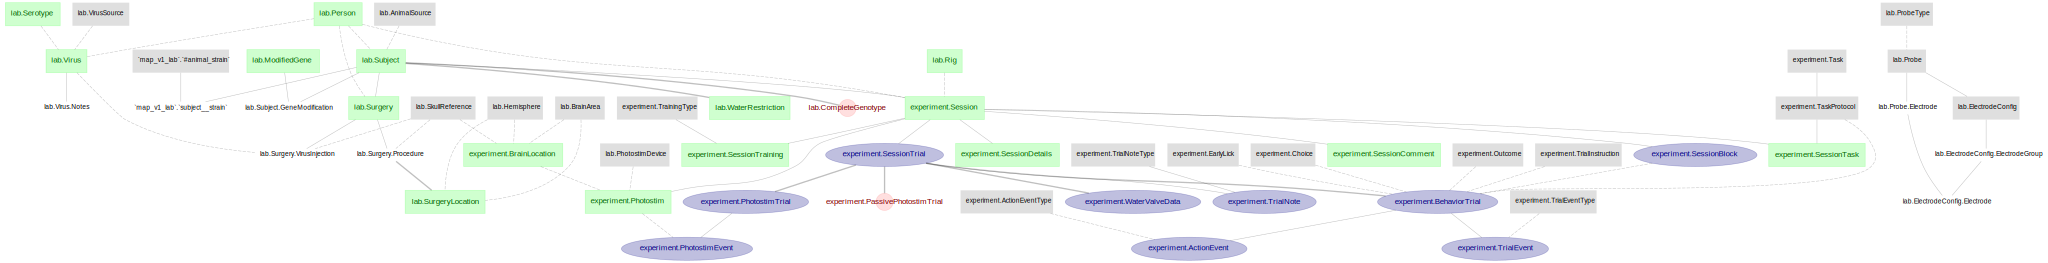

In [3]:
dj.Diagram(lab) + dj.ERD(experiment)

In [4]:
# Who're in the lab?
lab.Person.fetch(format='frame')

,fullname
username,
daveliu,Dave Liu
NT,Nai-Wen Tien
rozsam,Marton Rozsa
singha,Amrita Singh
susu,Susu Chen
Tina,Tina Pluntke


In [5]:
# How many rigs do we have?
lab.Rig.fetch(format='frame')

,room,rig_description
rig,,
Ephys1,2w.334,Recording computer
RRig,2w.334,Recording rig
RRig2,2w.334,Recording rig
Training-Tower-1,2w.339,training rig
Training-Tower-2,2w.339,training rig
Training-Tower-3,2w.339,training rig
TRig1,2w.334,Training rig 1
TRig2,2w.334,Training rig 2
TRig3,2w.334,Training rig 3


In [6]:
# Show all sessions with comments
pd.set_option('display.max_rows', None)
all_session = experiment.Session * behavioranal.SessionTrainingType * experiment.SessionComment * lab.WaterRestriction
all_session.fetch(format='frame').loc[:,:'water_restriction_number'].sort_values(['subject_id','session'])  # Hide irrelevant columns

session_date  \
subject_id session session_comment                                                   
447921     1       nan                                                  2019-09-11   
           2       100% vs 0%                                           2019-09-12   
           3       100% vs 0, 90 Vs10                                   2019-09-13   
           4       introduce early-lick punishment                      2019-09-14   
           5       difficulty 2 => 3, total reward:1 => 0.8 => 0.6...   2019-09-15   
           6       nan                                                  2019-09-16   
           7       nan                                                  2019-09-17   
           8       total reward: 0.5 => 0.45, delay: 1s => 2 s          2019-09-18   
           9       difficulty: 4; lickport too low                      2019-09-19   
           10      nan                                                  2019-09-20   
           11      nan                                                  2019-09-21   
           12      nan                                                  2019-09-22   
           13      nan                                                  2019-09-23   
           14      nan                                                  2019-09-24   
           15      remove 100:0 block                                   2019-09-25   
           16      nan                                                  2019-09-26   
           17      nan                                                  2019-09-27   
           18      nan                                                  2019-09-28   
           19      nan                                                  2019-09-30   
           20      nan                                                  2019-10-01   
           21      nan                                                  2019-10-02   
           22      nan                                                  2019-10-03   
           23      nan                                                  2019-10-04   
           24      nan                                                  2019-10-07   
           25      nan                                                  2019-10-08   
           26      nan                                                  2019-10-09   
           27      nan                                                  2019-10-10   
           28      nan                                                  2019-10-11   
           29      nan                                                  2019-10-15   
           30      nan                                                  2019-10-16   
           31      nan                                                  2019-10-17   
           32      nan                                                  2019-10-24   
           33      nan                                                  2019-10-25   
           34      nan                                                  2019-10-28   
           35      nan                                                  2019-10-29   
           36      nan                                                  2019-10-30   
           37      nan                                                  2019-10-31   
           38      nan                                                  2019-11-01   
452271     1       nan                                                  2020-01-19   
           2       nan                                                  2020-01-20   
           3       nan                                                  2020-01-22   
           4       nan                                                  2020-01-27   
           5       nan                                                  2020-01-28   
           6       nan                                                  2020-01-29   
           7       nan                                                  2020-01-30   
           8       nan      

HH: The session_comment should NOT be a primary key of .SessionComment ...

### Let's focus on the conventional 2-lickport foraging experiments done by Marton

In [6]:
all_2lp_foraging_session = all_session & 'username = "rozsam"'  & 'session_task_protocol = 100'\
                            & 'water_restriction_number = "FOR04"'
all_2lp_foraging_session.fetch(format='frame').loc[:,:'water_restriction_number']

session_date  \
subject_id session session_comment                                                   
453476     1       lickrate increased after moving lickport closer      2019-06-25   
           2       increased water valve time                           2019-06-26   
           3       nan                                                  2019-06-27   
           4       nan                                                  2019-06-28   
           5       she loves this task                                  2019-06-29   
           6       doing well                                           2019-06-30   
           7       not foraging at all, sticking to one lickport        2019-07-01   
           8       foraging a bit, but sticking to a lickport           2019-07-02   
           9       left biased, decreasing left valve time..            2019-07-03   
           10      switching..                                          2019-07-04   
           11      sticking to a lickport, foraging at the end          2019-07-05   
           12      sticking to a lickport seems like switching bas...   2019-07-06   
           13      transferred to rig3.. doesn't like it..              2019-07-07   
           14      increased water valve time, relatively nice per...   2019-07-08   
           15      yogi before training                                 2019-07-09   
           16      yogi before training                                 2019-07-10   
           17      yogi before training                                 2019-07-11   
           18      yogi before training                                 2019-07-12   
           19      yogi before training, triggered motor retraction     2019-07-13   
           20      yogi before training, triggered motor retraction     2019-07-14   
           21      yogi before training, triggered motor retraction     2019-07-15   
           22      yogi before training, triggered motor retraction     2019-07-16   
           23      yogi before training, triggered motor retraction     2019-07-17   
           24      yogi before training, triggered motor retraction     2019-07-18   
           25      yogi before training, triggered motor retraction     2019-07-19   
           26      increased ITI, triggered motor retraction            2019-07-20   
           27      yogi before training, triggered motor retraction     2019-07-21   
           28      yogi before training, triggered motor retraction     2019-07-22   

                                                                      session_time  \
subject_id session session_comment                                                   
453476     1       lickrate increased after moving lickport closer        21:31:44   
           2       increased water valve time                             20:20:03   
           3       nan                                                    21:34:05   
           4       nan                                                    20:23:13   
           5       she loves this task                                    20:22:18   
           6       doing well                                             19:34:12   
           7       not foraging at all, sticking to one lickport          19:51:56   
           8       foraging a bit, but sticking to a lickport             20:40:03   
           9       left biased, decreasing left valve time..              18:24:06   
           10      switching..                                            18:46:40   
           11      sticking to a lickport, foraging at the end            18:27:13   
           12      sticking to a lickport seems like switching bas...     19:44:03   
           13      transferred to rig3.. doesn't like it..                18:22:30   
           14      increased water valve time, relatively nice per...     17:39:49   
           15      yogi before training                                   17:36:30   
           16      yogi bef

### Seems that FOR04 has done a lot of 2lp experiments. Here's an example session.

Calling plot_local_psychometric_curve...


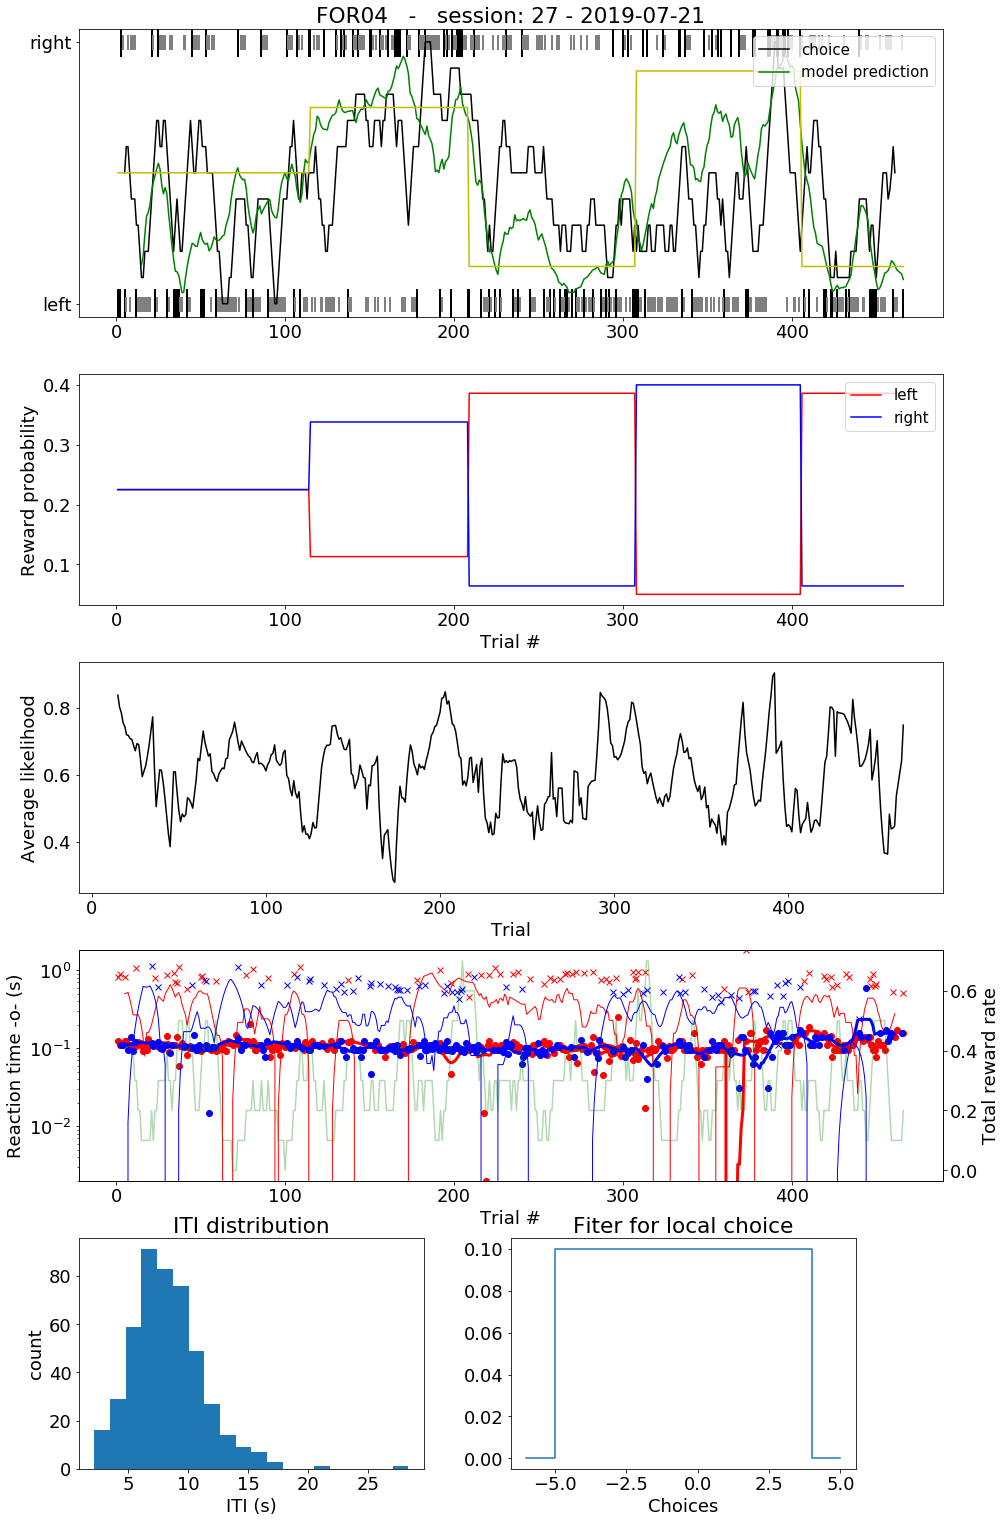

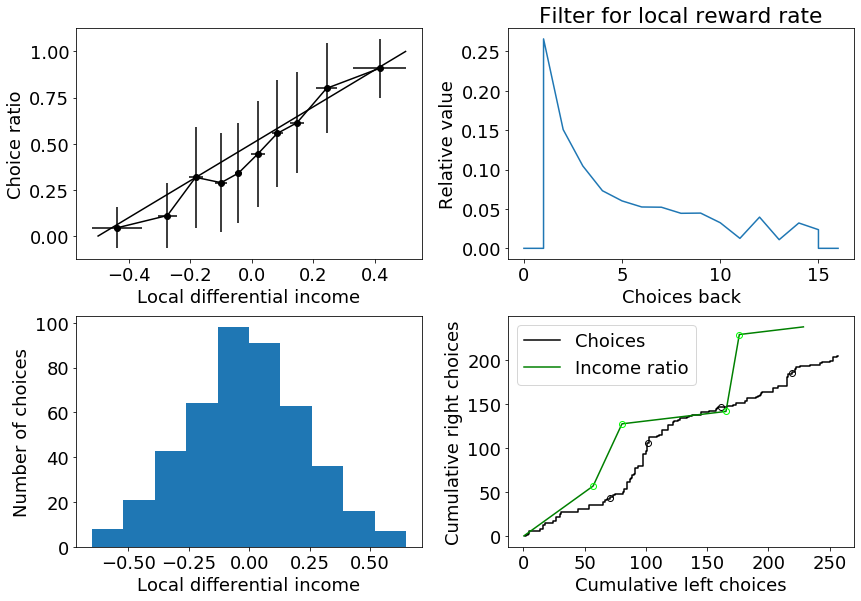

In [7]:
###plot the last session for the 3 lickport foraging mice:
# Let's try 2lp experiment first. HH
plot_one_session(wr_name = 'FOR04',session = 27)
#plot_one_session(wr_name = 'FOR04',session = 'last')

"\ntemp = plot_block_based_tuning_curves(wr_name = 'FOR10',\n                               minsession = 20,\n                               mintrialnum = 20,\n                               max_bias = 1,\n                               bootstrapnum = 100,\n                               only_blocks_above_median = False,\n                               only_blocks_above_mean = False,\n                               only_blocks_below_mean = False)\ntemp = plot_block_based_tuning_curves_three_lickports(wr_name = 'FOR09',\n                               minsession = 20,\n                               mintrialnum = 70,\n                               max_bias = 1,\n                               bootstrapnum = 100,\n                               only_blocks_above_median = False,\n                               only_blocks_above_mean = False,\n                               only_blocks_below_mean = False)\ntemp = plot_block_based_tuning_curves_three_lickports(wr_name = 'FOR10',\n         

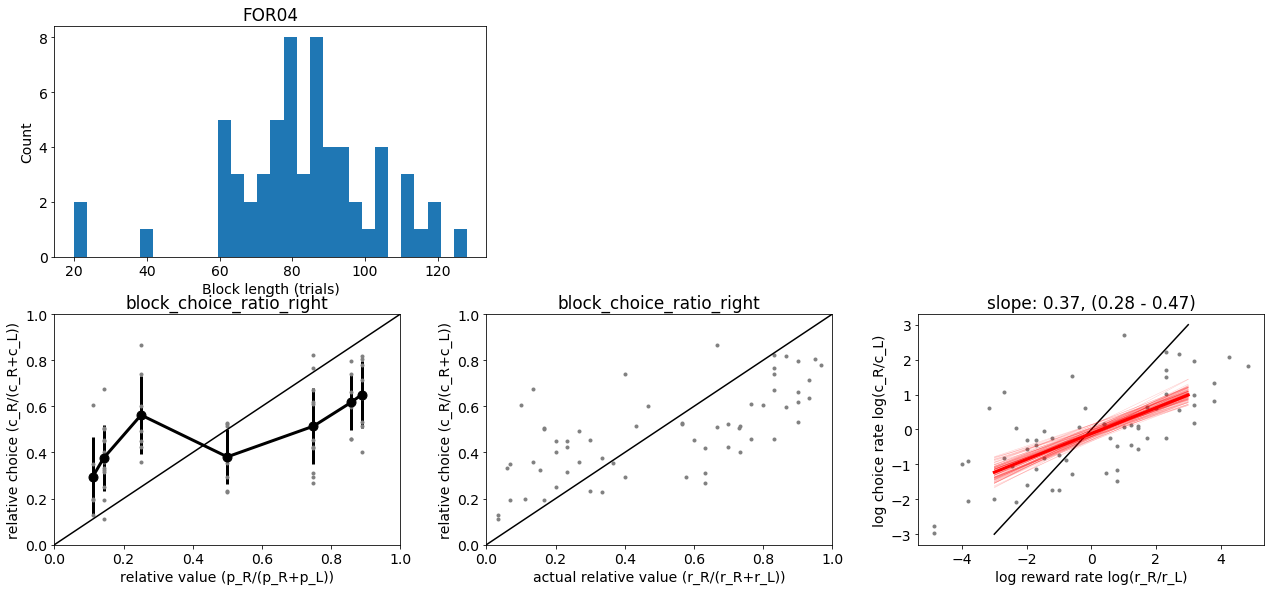

In [82]:
#block based tuning curves
temp = plot_block_based_tuning_curves(wr_name = 'FOR04',
                               minsession = 20,
                               mintrialnum = 20,
                               max_bias = 1,
                               bootstrapnum = 100,
                               only_blocks_above_median = False,
                               only_blocks_above_mean = False,
                               only_blocks_below_mean = False)
'''
temp = plot_block_based_tuning_curves(wr_name = 'FOR10',
                               minsession = 20,
                               mintrialnum = 20,
                               max_bias = 1,
                               bootstrapnum = 100,
                               only_blocks_above_median = False,
                               only_blocks_above_mean = False,
                               only_blocks_below_mean = False)
temp = plot_block_based_tuning_curves_three_lickports(wr_name = 'FOR09',
                               minsession = 20,
                               mintrialnum = 70,
                               max_bias = 1,
                               bootstrapnum = 100,
                               only_blocks_above_median = False,
                               only_blocks_above_mean = False,
                               only_blocks_below_mean = False)
temp = plot_block_based_tuning_curves_three_lickports(wr_name = 'FOR10',
                               minsession = 20,
                               mintrialnum = 70,
                               max_bias = 1,
                               bootstrapnum = 100,
                               only_blocks_above_median = False,
                               only_blocks_above_mean = False,
                               only_blocks_below_mean = False)
'''

/home/rozmar/anaconda3/envs/datajoint/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/home/rozmar/anaconda3/envs/datajoint/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/home/rozmar/anaconda3/envs/datajoint/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/home/rozmar/anaconda3/envs/datajoint/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


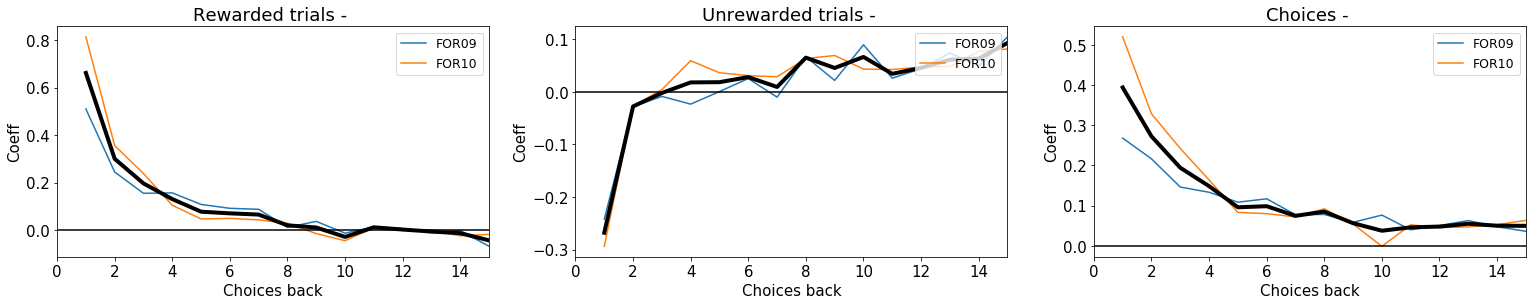

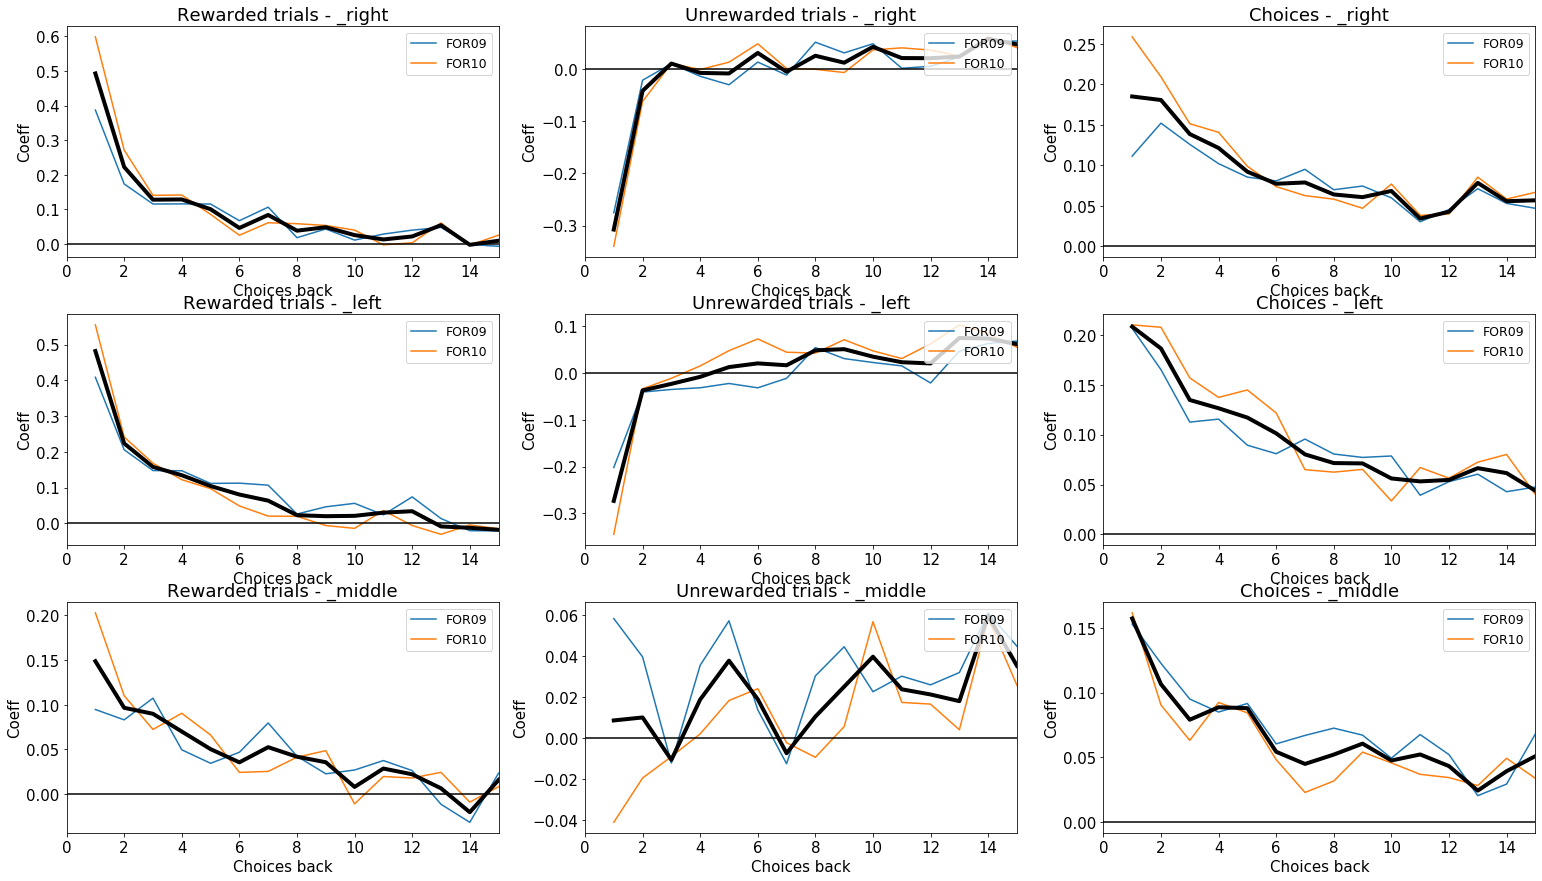

In [4]:
#plot regression coefficients
plot_regression_coefficients(plottype = 'RNRC',lickportnum = '2lp',subjects = ['FOR09','FOR10'])
plot_regression_coefficients(plottype = 'RNRC',lickportnum = '3lp',subjects = ['FOR09','FOR10'])

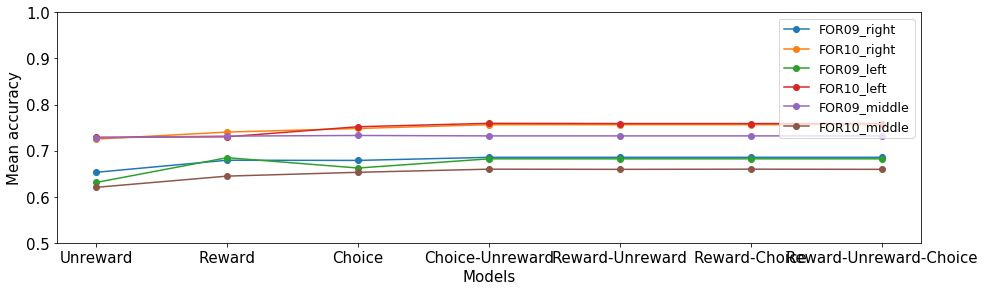

In [5]:
#gather and plot the scores for each logistic regression - this is not a nice workaround
fig=plt.figure()
ax1=fig.add_axes([0,0,2,.8])
subjects_needed = ['FOR09','FOR10']
df_subject_wr=pd.DataFrame(lab.WaterRestriction() * experiment.Session() * behavioranal.SubjectFittedChoiceCoefficients3lpR())
subject_names = df_subject_wr['water_restriction_number'].unique()
sortidx = np.argsort(subject_names)
subject_names.sort()
sortidx_new = list()
subject_names_new = list()

for idx,name in zip(sortidx,subject_names):
    if name in subjects_needed:
        sortidx_new.append(idx)
        subject_names_new.append(name)
subject_names = subject_names_new
sortidx = np.asarray(sortidx_new)

legend = list()
for legendname,scorename in zip(['right','left','middle'],['score_subject_right','score_subject_left','score_subject_middle']):

    logistic_score_R = np.asarray(behavioranal.SubjectFittedChoiceCoefficients3lpR.fetch(scorename),dtype = float)
    logistic_score_RNR = np.asarray(behavioranal.SubjectFittedChoiceCoefficients3lpRNR.fetch(scorename),dtype = float)
    logistic_score_RC = np.asarray(behavioranal.SubjectFittedChoiceCoefficients3lpRC.fetch(scorename),dtype = float)
    logistic_score_RNRC = np.asarray(behavioranal.SubjectFittedChoiceCoefficients3lpRNRC.fetch(scorename),dtype = float)
    logistic_score_NRC = np.asarray(behavioranal.SubjectFittedChoiceCoefficients3lpNRC.fetch(scorename),dtype = float)
    logistic_score_NR = np.asarray(behavioranal.SubjectFittedChoiceCoefficients3lpNR.fetch(scorename),dtype = float)
    logistic_score_C = np.asarray(behavioranal.SubjectFittedChoiceCoefficients3lpC.fetch(scorename),dtype = float)


    logistic_score_R= logistic_score_R[sortidx]
    logistic_score_RNR= logistic_score_RNR[sortidx]
    logistic_score_RC= logistic_score_RC[sortidx]
    logistic_score_RNRC= logistic_score_RNRC[sortidx]
    logistic_score_NRC= logistic_score_NRC[sortidx]
    logistic_score_NR= logistic_score_NR[sortidx]
    logistic_score_C= logistic_score_C[sortidx]

    for r,rnr,rc,rnrc,nrc,nr,c,name in zip(logistic_score_R,
                                           logistic_score_RNR,
                                           logistic_score_RC,
                                           logistic_score_RNRC,
                                           logistic_score_NRC,
                                           logistic_score_NR,
                                           logistic_score_C,
                                           subject_names,
                                          ):
        legend.append(name+'_'+legendname)
        if 'FOR' in name or 'HC' in name:
            ax1.plot(['Unreward','Reward','Choice','Choice-Unreward','Reward-Unreward','Reward-Choice','Reward-Unreward-Choice'],[nr,r,c,nrc,rnr,rc,rnrc],'o-')
        else:
            ax1.plot(['Unreward','Reward','Choice','Choice-Unreward','Reward-Unreward','Reward-Choice','Reward-Unreward-Choice'],[nr,r,c,nrc,rnr,rc,rnrc],'o--')

ax1.set_ylabel('Mean accuracy')
ax1.set_xlabel('Models')
ax1.set_ylim([.5,1])
ax1.legend(legend,fontsize='small',loc = 'upper right')


In [12]:
#pull raw behavior data for a single subject
subject_name = 'FOR04' # select a subject
subject_id = (lab.WaterRestriction() & 'water_restriction_number = "'+subject_name+'"').fetch('subject_id')[0]# get the unique subject ID - this is necessary for fetching the data
subject_id

453476

In [13]:
# these are all the trials for this subject
table = experiment.BehaviorTrial() & 'subject_id = ' +str(subject_id) 
table

subject_id institution 6 digit animal ID,session session number,trial trial number,block block number,task task type,task_protocol task protocol,trial_instruction,trial_choice,early_lick,outcome
453476,1,1,1,foraging,100,None,none,no early,ignore
453476,1,2,1,foraging,100,None,none,no early,ignore
453476,1,3,1,foraging,100,None,none,no early,ignore
453476,1,4,1,foraging,100,None,none,no early,ignore
453476,1,5,1,foraging,100,None,left,no early,hit
453476,1,6,1,foraging,100,None,none,no early,ignore
453476,1,7,1,foraging,100,None,none,early,ignore


In [14]:
# and the trials where the task was on 3 lickports ('session_task_protocol = 101' in the table behavioranal.SessionTrainingType())
table = experiment.BehaviorTrial() * behavioranal.SessionTrainingType() & 'subject_id = ' +str(subject_id) & 'session_task_protocol = 100'
table

subject_id institution 6 digit animal ID,session session number,trial trial number,block block number,task task type,task_protocol task protocol,trial_instruction,trial_choice,early_lick,outcome,session_task_protocol the number of the dominant task protocol in the session
453476,1,1,1,foraging,100,None,none,no early,ignore,100
453476,1,2,1,foraging,100,None,none,no early,ignore,100
453476,1,3,1,foraging,100,None,none,no early,ignore,100
453476,1,4,1,foraging,100,None,none,no early,ignore,100
453476,1,5,1,foraging,100,None,left,no early,hit,100
453476,1,6,1,foraging,100,None,none,no early,ignore,100
453476,1,7,1,foraging,100,None,none,early,ignore,100


In [15]:
# and the trials where the pretraining or bias check was over ('trial > session_pretraining_trial_num' in the behavioranal.SessionStats() table)
table = experiment.BehaviorTrial() * behavioranal.SessionStats() * behavioranal.SessionTrainingType() & 'subject_id = ' +str(subject_id) & 'trial > session_pretraining_trial_num' & 'session_task_protocol = 100'
table

subject_id institution 6 digit animal ID,session session number,trial trial number,block block number,task task type,task_protocol task protocol,trial_instruction,trial_choice,early_lick,outcome,session_trialnum number of trials,session_blocknum number of blocks,session_hits number of hits,session_misses number of misses,session_ignores number of ignores,session_autowaters number of autowaters,session_length length of the session in seconds,session_pretraining_trial_num number of pretraining trials,session_1st_3_ignores trialnum where the first three ignores happened in a row,session_1st_2_ignores trialnum where the first three ignores happened in a row,session_1st_ignore trialnum where the first ignore happened,session_task_protocol the number of the dominant task protocol in the session
453476,5,1,1,foraging,100,None,none,no early,ignore,630,7,197,379,54,0,3457.4055,0,12,11,1,100
453476,5,2,1,foraging,100,None,left,no early,hit,630,7,197,379,54,0,3457.4055,0,12,11,1,100
453476,5,3,1,foraging,100,None,left,no early,miss,630,7,197,379,54,0,3457.4055,0,12,11,1,100
453476,5,4,1,foraging,100,None,left,no early,miss,630,7,197,379,54,0,3457.4055,0,12,11,1,100
453476,5,5,1,foraging,100,None,left,no early,miss,630,7,197,379,54,0,3457.4055,0,12,11,1,100
453476,5,6,1,foraging,100,None,left,no early,miss,630,7,197,379,54,0,3457.4055,0,12,11,1,100
453476,5,7,1,foraging,100,None,left,no early,miss,630,7,197,379,54,0,3457.4055,0,12,11,1,100


In [10]:
#TO DO
#we can also get rid of the trials at the end of each session when the mouse wasn't really paying attention 
#e.g. when the cumulative ignore trials exceed a given number or the mouse ignores several trials in a row
#or when the reward rate drops..

In [16]:
#let's get the session number, trial number, the choice and the outcome of these trials
data = table.fetch('session','trial','trial_choice','outcome')
data

[array([ 5,  5,  5, ..., 28, 28, 28], dtype=int64),
 array([  1,   2,   3, ..., 513, 514, 515], dtype=int64),
 array(['none', 'left', 'left', ..., 'right', 'right', 'none'],
       dtype=object),
 array(['ignore', 'hit', 'miss', ..., 'miss', 'miss', 'ignore'],
       dtype=object)]

In [12]:
#get the random seeds
table_random_seeds = experiment.BehaviorTrial() * behavioranal.SessionStats() * behavioranal.SessionTrainingType() * experiment.TrialNote() & 'subject_id = ' +str(subject_id) & 'trial > session_pretraining_trial_num' & 'session_task_protocol = 101' & 'trial_note_type = "random_seed_start"'
random_seed_data = table_random_seeds.fetch('session','trial','trial_note')
random_seed_data

[array([41, 42, 43, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 53, 53, 53,
        53, 53, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]),
 array([ 96,   1,  48, 132, 124,  47,  56,  36,  48,  69, 125,  24,  69,
        219, 302, 350, 419, 435, 458, 471, 115,  65,  70, 104,  34,  88,
         33,  61,  93,  49,  51,  99]),
 array(['323', '324', '325', '325', '326', '327', '328', '329', '330',
        '331', '332', '333', '334', '335', '335', '335', '335', '335',
        '335', '335', '337', '338', '339', '341', '343', '344', '345',
        '346', '347', '348', '349', '350'], dtype=object)]

In [9]:
#iterate over all the subjects
#get the subject names (eg. 'FOR01','FOR02'...)
subject_names = lab.WaterRestriction().fetch('water_restriction_number') # fetch all the subject names
subject_names.sort() #sort it to look nicer

#subject_names = ['FOR09','FOR10'] # or name subjects manually

for subject_name in subject_names: # iterate over the subjects
    subject_id = (lab.WaterRestriction() & 'water_restriction_number = "'+subject_name+'"').fetch('subject_id')[0]# get the unique subject ID - this is necessary for fetching the data
    table = experiment.BehaviorTrial() * behavioranal.SessionStats() * behavioranal.SessionTrainingType() & 'subject_id = ' +str(subject_id) & 'trial > session_pretraining_trial_num' & 'session_task_protocol = 100'
    if len(table) >0: # proceed only if that particular mouse has some trials
        print(subject_name)
        # you fetch what you need

FOR01
FOR02
FOR03
FOR04
FOR05
FOR06
FOR07
FOR08
FOR09
FOR10
FOR11
FOR12
FOR13
FOR14
HC16
